# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Import Packages

In [1]:
import os
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

## Image Pipeline

### Camera Calibration

In [2]:
def calibrate(num_corners_x, num_corners_y, input_folder, output_folder, file_pattern):
    """Calibrate the camera based on Chessboard images"""
    
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ..., (8,5,0)
    objp = np.zeros((num_corners_x * num_corners_y, 3), np.float32)
    objp[:, :2] = np.mgrid[0:num_corners_x, 0:num_corners_y].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane.

    # Collect image files
    image_files = glob.glob(os.path.join(input_folder, file_pattern))
    
    # Step through the images and search for chessboard corners    
    for file in image_files:
        img = cv2.imread(file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        res, corners = cv2.findChessboardCorners(gray, (num_corners_x, num_corners_y), None)

        if res == True:
            # Add object and image points if corners are found
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            path, filename = os.path.split(file)
            cv2.drawChessboardCorners(img, (num_corners_x, num_corners_y), corners, res)
            cv2.imwrite(os.path.join(output_folder, filename), img)
        else:
            print("Corners not found in image:", file)

    # Get image size from one of the images
    img = cv2.imread(image_files[0])
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    res, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return mtx, dist

In [3]:
# Calibrate camera and save calibration parameters
camera_matrix, camera_distortion = calibrate(num_corners_x=9, num_corners_y=6, 
    input_folder="calib", output_folder="calib/output", 
    file_pattern="calibration*.jpg")

Corners not found in image: calib/calibration5.jpg
Corners not found in image: calib/calibration1.jpg
Corners not found in image: calib/calibration4.jpg


### Image Distortion Correction

In [4]:
def undistort(image, mtx, dist):
    """Undistort an image"""
    return cv2.undistort(image, mtx, dist, None, mtx)

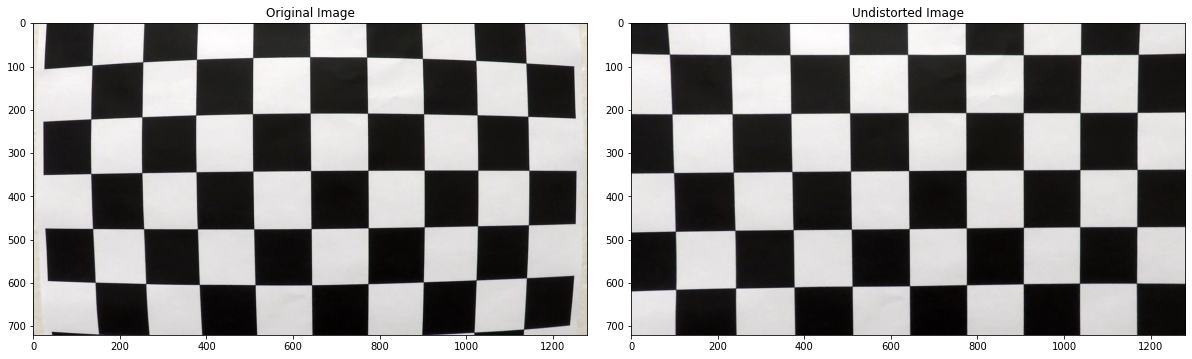

In [5]:
# Undistort example Chessboard image as a test
image = cv2.imread("calib/calibration1.jpg")
undistorted_image = undistort(image, camera_matrix, camera_distortion)
cv2.imwrite("calib/output/calibration1_undist.jpg", undistorted_image);

# Plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
f.tight_layout()
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image')
ax2.imshow(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Binary Image Conversion

In [6]:
def binary(img, s_thresh=(170, 255), sx_thresh=(20, 100), colored=False):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    
    # Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    if colored:
        # Stack each channel
        binary = np.dstack((np.zeros_like(sx_binary), sx_binary, s_binary)) * 255
    else:
        binary = np.zeros_like(sx_binary)
        binary[(s_binary == 1) | (sx_binary == 1)] = 1

    return binary

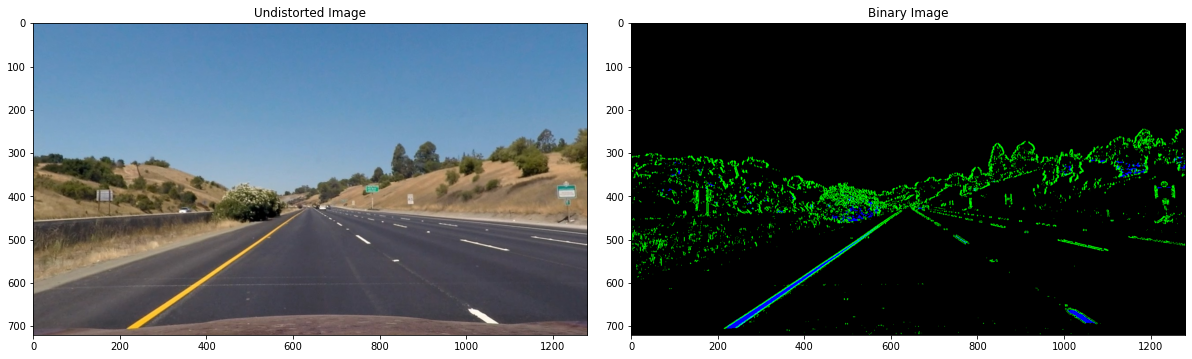

In [7]:
# Undistort and convert example image 
image = cv2.imread("images/straight_lines1.jpg")
undistorted_image = undistort(image, camera_matrix, camera_distortion)
binary_image = binary(undistorted_image, colored=True)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
f.tight_layout()
ax1.imshow(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Undistorted Image')
ax2.imshow(binary_image, cmap=None if binary_image.ndim > 2 else 'gray')
ax2.set_title('Binary Image')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Perspective Transform

In [8]:
def warp(image, transformation_matrix):
    """Warp an image"""    
    img_size = (image.shape[1], image.shape[0])
    return cv2.warpPerspective(image, transformation_matrix, img_size, flags=cv2.INTER_NEAREST) # flags=cv2.INTER_NEAREST is omitting smoothing

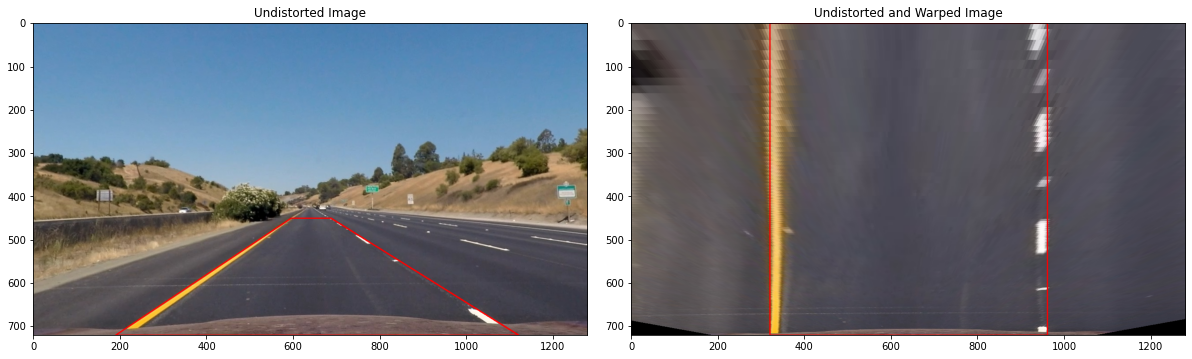

In [235]:
# Undistort example image 
image = cv2.imread("images/straight_lines1.jpg")
undistorted_image = undistort(image, camera_matrix, camera_distortion)

# Define source and destination coordinate points
img_size = (image.shape[1], image.shape[0])
src_coord = np.float32([
    [595, 450],
    [190, 720],
    [1120, 720],
    [687, 450]
])
dst_coord = np.float32([
    [(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]
])
# Given src and dst coordinate points, calculate the perspective transform matrix
transformation_matrix = cv2.getPerspectiveTransform(src_coord, dst_coord)
inv_transformation_matrix = cv2.getPerspectiveTransform(dst_coord, src_coord)

# Warp undistorted image
warped_image = warp(undistorted_image, transformation_matrix)

# Add polygons and save images
thickness = 2
color = (0, 0, 255)  # Red color in BGR
pts = np.int32(src_coord.reshape((-1, 1, 2)))
undist = cv2.polylines(np.copy(undistorted_image), [pts], True, color, thickness)
cv2.imwrite("images/output/straight_lines1_undistorted.jpg", undist);
pts = np.int32(dst_coord.reshape((-1, 1, 2)))
warped = cv2.polylines(np.copy(warped_image), [pts], True, color, thickness)
cv2.imwrite("images/output/straight_lines1_warped.jpg", warped);

# Plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
f.tight_layout()
ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
ax1.set_title('Undistorted Image')
ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted and Warped Image')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Line Detection

In [219]:
def find_lane_lines(image, visualize=False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    
    if visualize:
        # Create an output image to draw on and visualize the result
        output_image = np.dstack((image, image, image))
        
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = int(image.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_line_inds = []
    right_line_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window + 1) * window_height
        win_y_high = image.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if visualize:
            # Draw the windows on the visualization image
            cv2.rectangle(output_image, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2) 
            cv2.rectangle(output_image, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_line_inds.append(good_left_inds)
        right_line_inds.append(good_right_inds)
        
        # Recenter next window if more than minpix pixels are found
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_line_inds = np.concatenate(left_line_inds)
        right_line_inds = np.concatenate(right_line_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_line_inds]
    lefty = nonzeroy[left_line_inds] 
    rightx = nonzerox[right_line_inds]
    righty = nonzeroy[right_line_inds]

    if visualize:
        return plot_polynomial(output_image, leftx, lefty, rightx, righty)
    else:
        return leftx, lefty, rightx, righty

def search_around_polynomial(image, left_fit, right_fit, margin=100, visualize=False):
    """Search lane lines around polynomial"""
    
    # Grab activated pixels
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values within the +/- margin of our polynomial function
    left_line_inds = ((nonzerox > (left_fit[0] * (nonzeroy**2) + left_fit[1] * nonzeroy + left_fit[2] - margin)) & 
                      (nonzerox < (left_fit[0] * (nonzeroy**2) + left_fit[1] * nonzeroy + left_fit[2] + margin)))
    right_line_inds = ((nonzerox > (right_fit[0] * (nonzeroy**2) + right_fit[1] * nonzeroy + right_fit[2] - margin)) & 
                       (nonzerox < (right_fit[0] * (nonzeroy**2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_line_inds]
    lefty = nonzeroy[left_line_inds] 
    rightx = nonzerox[right_line_inds]
    righty = nonzeroy[right_line_inds]

    # Visualization
    if visualize:
        # Create an output image to draw on and visualize the result
        output_image = np.dstack((image, image, image))
        return plot_polynomial(output_image, leftx, lefty, rightx, righty, margin)
    else:
        return leftx, lefty, rightx, righty

def fit_polynomial(leftx, lefty, rightx, righty):
    """Fit a second order polynomial to each lane line using `np.polyfit`"""
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

def plot_polynomial(image, leftx, lefty, rightx, righty, margin=0):
    # Fit polynomial
    left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty)
    
    # Calc both polynomials using ploty, left_fit and right_fit
    ploty = np.linspace(0, image.shape[0] - 1, image.shape[0])
    try:
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print("The function failed to fit a line!")
        left_fitx = 1 * ploty**2 + 1 * ploty
        right_fitx = 1 * ploty**2 + 1 * ploty
        
    # Colors in the left and right lane regions
    image[lefty, leftx] = [255, 0, 0]
    image[righty, rightx] = [0, 0, 255]

    left_line = np.array([np.flipud(np.transpose(np.vstack([left_fitx, ploty])))])
    right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    thickness = 6
    color = (255, 255, 0)
    cv2.polylines(image, np.int_([left_line]), False, color, thickness)
    cv2.polylines(image, np.int_([right_line]), False, color, thickness)

    if margin > 0:
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        window_image = np.zeros_like(image)
        cv2.fillPoly(window_image, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(window_image, np.int_([right_line_pts]), (0, 255, 0))
        image = cv2.addWeighted(image, 1, window_image, 0.3, 0)        

    return image

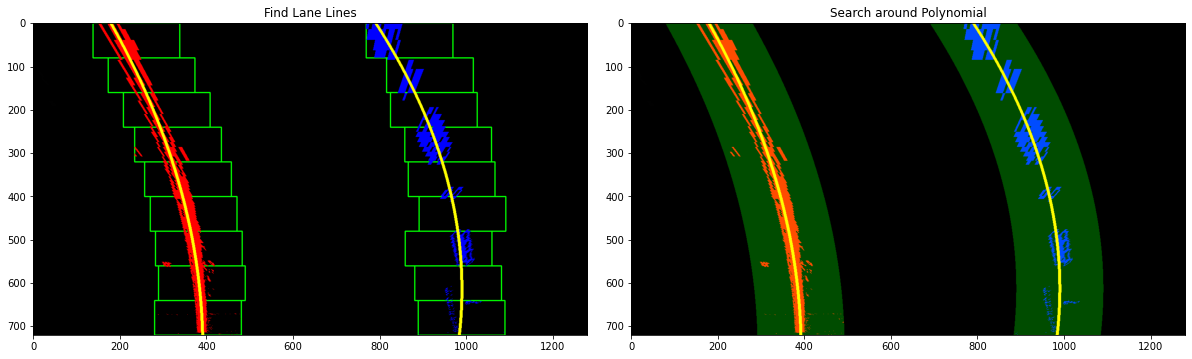

In [241]:
# Undistort, convert and warp example image for lane lines detection
image = cv2.imread("images/test2.jpg")
undistorted_image = undistort(image, camera_matrix, camera_distortion)
binary_image = binary(undistorted_image)
warped_image = warp(binary_image, transformation_matrix)

# Find lane lines and fit polynomial
leftx, lefty, rightx, righty = find_lane_lines(warped_image)
left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty)

# Visualize results
image_find_lane_lines = find_lane_lines(warped_image, visualize=True)
image_search_around_polynomial = search_around_polynomial(warped_image, left_fit, right_fit, visualize=True)

# Plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
f.tight_layout()
ax1.imshow(image_find_lane_lines)
ax1.set_title('Find Lane Lines')
ax2.imshow(image_search_around_polynomial)
ax2.set_title('Search around Polynomial')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Measure Curvature and Get Vehicle Position

In [292]:
def measure_position_curvature(left_fit, right_fit, y, center):
    """
    Measure relative vehicle position and lane curvature
    
    Calculates the relative position of the vehicle within the lane and 
    the curvature of the polynomial functions in meters.
    
    A negative position value indicates the vehicle is on the left side 
    from the center line.
    """
    
    # Define conversions in x and y from pixels space to meters
    my = 27 / 720 # meters per pixel in y dimension
    mx = 3.7 / 640 # meters per pixel in x dimension
    
    # Convert parabola coefficients from pixels into meters and 
    #  calculate the curvature of polynomial functions. The approach
    #  is based on a students suggestion in lesson 8.
    A = mx / (my**2) * left_fit[0]
    B = mx / my * left_fit[1]
    left_curverad_m = calc_curve_radius(A, B, y * my)
    A = mx / (my**2) * right_fit[0]
    B = mx / my * right_fit[1]
    right_curverad_m = calc_curve_radius(A, B, y * my)
    curverad_m = (left_curverad_m + right_curverad_m) / 2
    
    leftx_pos = left_fit[0] * (y**2) + left_fit[1] * y + left_fit[2]
    rightx_pos = right_fit[0] * (y**2) + right_fit[1] * y + right_fit[2]
    rel_pos = center - (leftx_pos + rightx_pos) / 2
    rel_pos_m = rel_pos * mx
    
    return rel_pos_m, curverad_m, left_curverad_m, right_curverad_m

def calc_curve_radius(A, B, y):
    return (1 + (2 * A * y + B)**2)**1.5 / np.abs(2 * A)

In [293]:
# Calculate the radius of curvature in pixels for both lane lines
rel_pos, curverad, left_curverad, right_curverad = measure_position_curvature(left_fit, right_fit, warped_image.shape[0], warped_image.shape[1]//2)
print("Relative position in lane: {:.2f} m".format(rel_pos))
print("Mean curve radius:  {:.2f} m".format(curverad))
print("Left curve radius:  {:.2f} m".format(left_curverad))
print("Right curve radius: {:.2f} m".format(right_curverad))

Relative position in lane: -0.15 m
Mean curve radius:  381.50 m
Left curve radius:  354.01 m
Right curve radius: 408.99 m


### Map Lane onto Road

In [294]:
def map_lane(image, warped_image, inv_transformation_matrix, leftx, lefty, rightx, righty, left_fit, right_fit):
    output_image = np.dstack((warped_image, warped_image, warped_image))
    
    # Calc both polynomials using ploty, left_fit and right_fit
    ploty = np.linspace(0, warped_image.shape[0] - 1, warped_image.shape[0])
    try:
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print("The function failed to fit a line!")
        left_fitx = 1 * ploty**2 + 1 * ploty
        right_fitx = 1 * ploty**2 + 1 * ploty
    
    # Colors in the left and right lane regions
    output_image[lefty, leftx] = [255, 0, 0]
    output_image[righty, rightx] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    line_pts = np.hstack((left_line, right_line))

    # Draw the lane onto the warped blank image
    lane_image = np.zeros_like(output_image)
    cv2.fillPoly(lane_image, np.int_([line_pts]), (0, 255, 0))
    output_image = cv2.addWeighted(output_image, 1, lane_image, 0.3, 0)        

    output_image = warp(output_image, inv_transformation_matrix)
    output_image = cv2.addWeighted(image, 1, output_image, 1, 0)

    return output_image

def add_info(image, rel_pos, curverad):
    info = "Relative position of vehicle in lane = {: .02f} m   |   Curve radius = {:.0f} m".format(rel_pos, curverad)
    return cv2.putText(image, info, org=(10, 40), fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                       fontScale=1, color=(255, 255, 255), thickness=2)


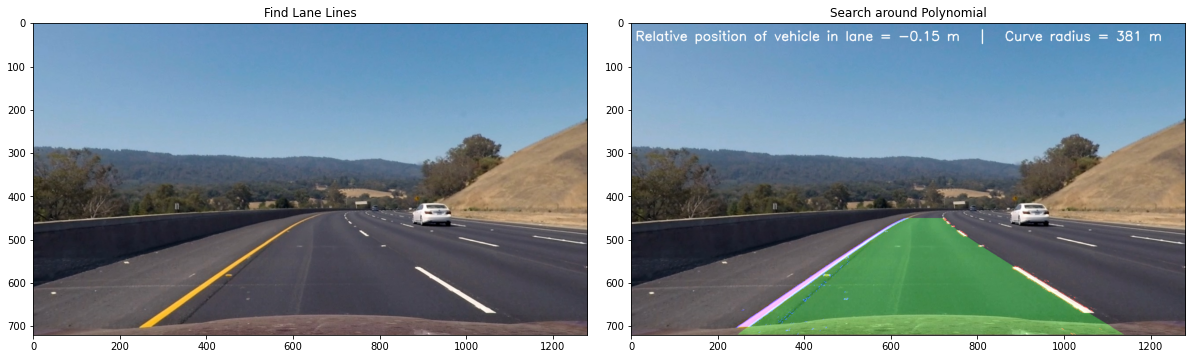

In [295]:
mapped_lane_image = map_lane(undistorted_image, warped_image, inv_transformation_matrix, 
                             leftx, lefty, rightx, righty, left_fit, right_fit)
mapped_lane_image = add_info(mapped_lane_image, rel_pos, curverad)

# Plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
f.tight_layout()
ax1.imshow(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Find Lane Lines')
ax2.imshow(cv2.cvtColor(mapped_lane_image, cv2.COLOR_BGR2RGB))
ax2.set_title('Search around Polynomial')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Process example images

In [296]:
image_files = glob.glob("images/*.jpg")
for file in image_files:
    image = cv2.imread(file)
    path, filename = os.path.split(file)

    # Undistort image
    undistorted_image = undistort(image, camera_matrix, camera_distortion)
    cv2.imwrite(os.path.join("images/output/undistorted", filename), undistorted_image)

    # Convert to binary
    binary_image = binary(undistorted_image)
    binary_image_debug = binary(undistorted_image, colored=True)
    cv2.imwrite(os.path.join("images/output/binary", filename), binary_image_debug)

    # Warp image
    warped_image = warp(binary_image, transformation_matrix)
    warped_image_debug = warp(undistorted_image, transformation_matrix)
    cv2.imwrite(os.path.join("images/output/warped", filename), warped_image_debug)
    
    # Find lane lines and fit polynomial
    leftx, lefty, rightx, righty = find_lane_lines(warped_image)
    left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty)
    
    find_lane_image = find_lane_lines(warped_image, visualize=True)
    cv2.imwrite(os.path.join("images/output/find_lane", filename), cv2.cvtColor(find_lane_image, cv2.COLOR_RGB2BGR))
    
    search_poly_image = search_around_polynomial(warped_image, left_fit, right_fit, visualize=True)
    cv2.imwrite(os.path.join("images/output/fit_poly", filename), cv2.cvtColor(search_poly_image, cv2.COLOR_RGB2BGR))
    
    rel_pos, curverad, left_curverad, right_curverad = measure_position_curvature(left_fit, right_fit, warped_image.shape[0], warped_image.shape[1]//2)
    mapped_lane_image = map_lane(undistorted_image, warped_image, inv_transformation_matrix, 
                                 leftx, lefty, rightx, righty, left_fit, right_fit)
    mapped_lane_image = add_info(mapped_lane_image, rel_pos, curverad)
    cv2.imwrite(os.path.join("images/output/mapped", filename), mapped_lane_image)

## Video Pipeline

In [29]:
class Line:
    pass

def process(image):
    undistorted_image = undistort(img, camera_matrix, camera_distortion)
    binary_image = binary(undistorted_image)